In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys, json

sns.set_palette("muted")
sns.set_context("talk")
sns.set_style("white")
pd.set_option("display.max_columns", None)

plt.rcParams['font.family']='NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

In /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.

### create rectangle

In [2]:
# do not save as file, but use on memory
import geopandas as gpd
from shapely.geometry import MultiPoint

def create_rec(x, y, width, height, angle):
    h_half = height/2
    w_half = width/2
    a_rad = np.deg2rad(angle)
    
    def get_coord(h_half, w_half, a_rad):
        X = x + h_half * np.sin(a_rad) - w_half * np.cos(a_rad)
        Y = y + h_half * np.cos(a_rad) + w_half * np.sin(a_rad)
        return (X, Y)
    
    points = [get_coord(h_half, w_half, a_rad),
              get_coord(-h_half, w_half, a_rad),
              get_coord(-h_half, -w_half, a_rad),
              get_coord(h_half, -w_half, a_rad)
             ]
    
    rec = gpd.GeoDataFrame({"points":[points], "geometry":[MultiPoint(points).convex_hull]})
    return rec

In [3]:
rec = create_rec(0, 0, 30, 10, 15)
rec

,points,geometry
0,"[(-13.194792168823422, 8.711914807983153), (-1...","POLYGON ((13.19479 -8.71191, -15.78298 -0.9473..."


<AxesSubplot:>

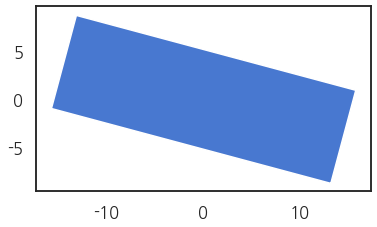

In [4]:
rec.plot()

### diurnal motion of the sun

> $\varphi$ : latitude (위도)  
> $\delta$ : declination (적위)  
> $H$ : azimuthal angle (태양의 방위각)  
> $Z$ : altitude angle (태양의 고도)  

$\sin{A} = (\sin{\delta} \cdot \sin{\varphi}) + (\cos{\delta} \cdot \cos{\varphi} \cdot \cos{H})$

> 춘분 & 추분 ($\delta = 0^{\circ}$)

$A = \arcsin{(\cos{\varphi} \cdot \cos{H})}$


In [5]:
def Z(H, lat):
    return np.rad2deg(np.arcsin(np.cos(np.deg2rad(lat))*np.cos(np.pi - np.deg2rad(Hs))))

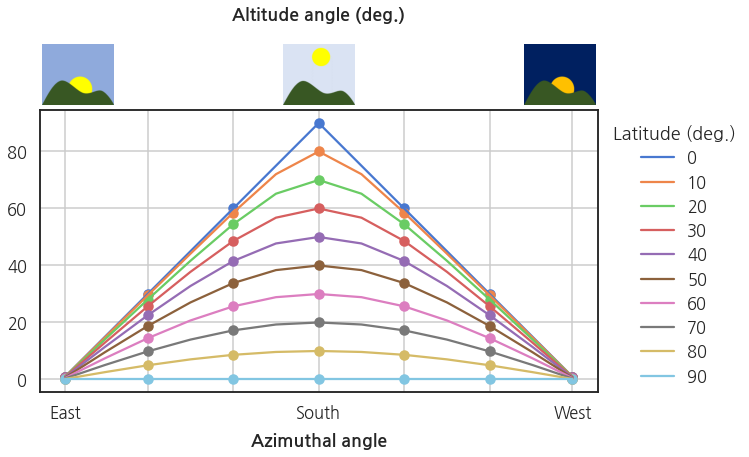

In [81]:
Hs = np.linspace(90, 270, 25)
Hs[0] += 1
Hs[-1] -= 1

fig, ax = plt.subplots(figsize=(10,10))
lines = []
for lat in range(0, 100, 10):
    if lat >= 0:
        Hs = np.linspace(90, 270, 13)
        sign = 1
    else:
        Hs = np.linspace(270, 450, 13)
        sign = -1
    Hs[0] += 1
    Hs[-1] -= 1
    As = sign * np.rad2deg(np.arcsin(np.cos(np.deg2rad(lat))*np.cos(np.pi - np.deg2rad(Hs))))
    
    ax.scatter([H for i, H in enumerate(Hs) if i%2 == 0], [A for i, A in enumerate(As) if i%2 == 0])
    line = ax.plot(Hs, As)
    lines.append(line)

ax.set_aspect("equal")
ax.grid()
ax.set_xticks([H for i, H in enumerate(Hs) if i%2 == 0])
xticklabels = [""]*len(ax.get_xticks())
xticklabels[0] = "East"
xticklabels[int(len(ax.get_xticks())/2)] = "South"
xticklabels[-1] = "West"
ax.set_xticklabels(xticklabels)
ax.set_xlabel("Azimuthal angle", fontdict={"fontweight":"bold"}, labelpad=12)
ax.set_title("Altitude angle (deg.)", fontdict={"fontweight":"bold"}, pad=90)

plt.legend(list(range(0, 100, 10)), bbox_to_anchor=(1,1), frameon=False, title="Latitude (deg.)")

im_sunrise = plt.imread("sunrise.png")
ax_sunrise = fig.add_axes([0.128, 0.69, 0.1, 0.1], anchor="NW", zorder=2)
ax_sunrise.imshow(im_sunrise)
ax_sunrise.axis("off")

im_suntop = plt.imread("suntop.png")
ax_suntop = fig.add_axes([0.463, 0.69, 0.1, 0.1], anchor="NW", zorder=2)
ax_suntop.imshow(im_suntop)
ax_suntop.axis("off")


im_sunset = plt.imread("sunset.png")
ax_sunset = fig.add_axes([0.798, 0.69, 0.1, 0.1], anchor="NW", zorder=2)
ax_sunset.imshow(im_sunset)
ax_sunset.axis("off")

plt.show()

### create shadow

In [7]:
def create_shadow_1(lat, 
                  src_x, src_y, src_width, src_height, src_tall, src_angle):
    sign = np.sign(lat)
    if sign >= 0:
        Hs = np.linspace(90, 270, 13)
    else:
        Hs = np.linspace(270, 450, 13)
    Hs[0] += 1
    Hs[-1] -= 1
    As = sign * np.rad2deg(np.arcsin(np.cos(np.deg2rad(lat))*np.cos(np.pi - np.deg2rad(Hs))))
    
    def get_shadows(tall, As, Hs):
        
        # shadow length
        ls = tall/np.tan(np.deg2rad(As))
        
        # shadow points
        s_points = []
        rec = create_rec(src_x, src_y, src_width, src_height, src_angle)
        points = rec.loc[0, "points"]
        
        for px, py in points:
            sx = px-ls*np.sin(np.deg2rad(Hs))
            sy = py-ls*np.cos(np.deg2rad(Hs))
            s_points.append(list(zip(sx, sy)))

        shadows_list = []
        for i in range(len(Hs)):
            mpoints_i = MultiPoint(points + np.array(s_points)[:,i].tolist())
            shadows_list.append(mpoints_i)
            
        shadows = gpd.GeoDataFrame({"geometry":shadows_list})

        return shadows
    
    shadows = get_shadows(src_tall, As, Hs)
    
    return shadows
    
    
shadows = create_shadow_1(37, 0, 0, 30, 10, 100, 15)    
shadows

,geometry
0,"MULTIPOINT (-13.195 8.712, -15.783 -0.947, 13...."
1,"MULTIPOINT (-13.195 8.712, -15.783 -0.947, 13...."
2,"MULTIPOINT (-13.195 8.712, -15.783 -0.947, 13...."
3,"MULTIPOINT (-13.195 8.712, -15.783 -0.947, 13...."
4,"MULTIPOINT (-13.195 8.712, -15.783 -0.947, 13...."
5,"MULTIPOINT (-13.195 8.712, -15.783 -0.947, 13...."
6,"MULTIPOINT (-13.195 8.712, -15.783 -0.947, 13...."
7,"MULTIPOINT (-13.195 8.712, -15.783 -0.947, 13...."
8,"MULTIPOINT (-13.195 8.712, -15.783 -0.947, 13...."
9,"MULTIPOINT (-13.195 8.712, -15.783 -0.947, 13...."


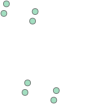

In [8]:
shadows.loc[5, "geometry"]

In [107]:
from scipy.special import cotdg

def create_shadow_2(lat, 
                  src_x, src_y, src_width, src_height, src_tall, src_angle):
    if lat >= 0:
        Hs = np.linspace(90, 270, 13)
        sign = 1
    else:
        Hs = np.linspace(270, 450, 13)
        sign = -1
    Hs[0] += 1
    Hs[-1] -= 1
    As = sign * np.rad2deg(np.arcsin(np.cos(np.deg2rad(lat))*np.cos(np.pi - np.deg2rad(Hs))))
    
    def get_shadows(tall, As, Hs):
        
        # shadow length
        ls = tall/np.tan(np.deg2rad(As))
        
        # shadow points
        s_points = []
        rec = create_rec(src_x, src_y, src_width, src_height, src_angle)
        points = rec.loc[0, "points"]
        
        for px, py in points:
            sx = px-ls*np.sin(np.deg2rad(Hs))
            sy = py-ls*np.cos(np.deg2rad(Hs))
            s_points.append(list(zip(sx, sy)))

        shadows_list = []
        for i in range(len(Hs)):
            mpoints_i = MultiPoint(points + np.array(s_points)[:,i].tolist())
            shadows_list.append(mpoints_i.convex_hull)
            
        shadows = gpd.GeoDataFrame({"geometry":shadows_list})

        return shadows
    
    shadows = get_shadows(src_tall, As, Hs)
    
    return shadows
    
    
shadows_2 = create_shadow_2(37, 0, 0, 30, 10, 100, 15)    
shadows_2

,geometry
0,"POLYGON ((13.195 -8.712, -7159.589 116.489, -7..."
1,"POLYGON ((13.195 -8.712, -15.783 -0.947, -444...."
2,"POLYGON ((13.195 -8.712, -15.783 -0.947, -214...."
3,"POLYGON ((13.195 -8.712, -15.783 -0.947, -119...."
4,"POLYGON ((13.195 -8.712, -15.783 -0.947, -67.9..."
5,"POLYGON ((13.195 -8.712, -15.783 -0.947, -37.1..."
6,"POLYGON ((13.195 -8.712, -15.783 -0.947, -15.7..."
7,"POLYGON ((13.195 -8.712, -15.783 -0.947, -13.1..."
8,"POLYGON ((13.195 -8.712, -15.783 -0.947, -13.1..."
9,"POLYGON ((13.195 -8.712, -15.783 -0.947, -13.1..."


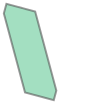

In [108]:
shadows_2.loc[5, "geometry"]

(-200.0, 200.0)

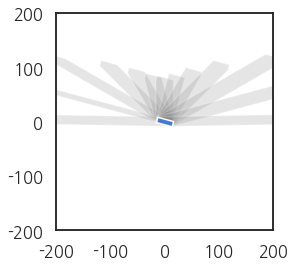

In [109]:
fig, ax = plt.subplots()
shadows_2.plot(ax=ax, facecolor="gray", alpha=0.2)
rec.plot(ax=ax)
ax.set_xlim(-200, 200)
ax.set_ylim(-200, 200)

### create shadow on target building rooftop

In [12]:
def create_shadow_3(lat, 
                   src_x, src_y, src_width, src_height, src_tall, src_angle,
                   tgt_x, tgt_y, tgt_width, tgt_height, tgt_tall, tgt_angle,
                   on):
    sign = np.sign(lat)
    if sign >= 0:
        Hs = np.linspace(90, 270, 13)
    else:
        Hs = np.linspace(270, 450, 13)
    Hs[0] += 1
    Hs[-1] -= 1
    As = sign * np.rad2deg(np.arcsin(np.cos(np.deg2rad(lat))*np.cos(np.pi - np.deg2rad(Hs))))
    
    # relative height 
    rel_tall = src_tall - tgt_tall
    if rel_tall < 0:
        rel_tall = 0
        
    if on == "ground":
        tall = src_tall
    else: # if on == "target"
        tall = rel_tall
    
    def get_shadows(tall, As, Hs, on):
        assert on in ["ground", "target"]
        
        # shadow length
        ls = tall/np.tan(np.deg2rad(As))
        
        # shadow points
        s_points = []
        rec = create_rec(src_x, src_y, src_width, src_height, src_angle)
        points = rec.loc[0, "points"]
        
        for px, py in points:
            sx = px-ls*np.sin(np.deg2rad(Hs))
            sy = py-ls*np.cos(np.deg2rad(Hs))
            s_points.append(list(zip(sx, sy)))

        shadows_list = []
        for i in range(len(Hs)):
            mpoints_i = MultiPoint(points + np.array(s_points)[:,i].tolist())
            shadows_list.append(mpoints_i.convex_hull)
            
        shadows = gpd.GeoDataFrame({"geometry":shadows_list})

        return shadows
    
    if on == "ground":
        shadows = get_shadows(src_tall, As, Hs, on)
    else:
        shadows = get_shadows(rel_tall, As, Hs, on)
    
    return shadows
    
    
shadows_3 = create_shadow_3(37, 0, 0, 30, 10, 100, 15,
                            20, 20, 20, 20, 60, 60,
                            "target"
                           )    
shadows_3

,geometry
0,"POLYGON ((13.195 -8.712, -2855.919 41.369, -28..."
1,"POLYGON ((13.195 -8.712, -15.783 -0.947, -198...."
2,"POLYGON ((13.195 -8.712, -15.783 -0.947, -95.3..."
3,"POLYGON ((13.195 -8.712, -15.783 -0.947, -57.1..."
4,"POLYGON ((13.195 -8.712, -15.783 -0.947, -36.6..."
5,"POLYGON ((13.195 -8.712, -15.783 -0.947, -24.3..."
6,"POLYGON ((13.195 -8.712, -15.783 -0.947, -15.7..."
7,"POLYGON ((13.195 -8.712, -15.783 -0.947, -13.1..."
8,"POLYGON ((13.195 -8.712, -15.783 -0.947, -13.1..."
9,"POLYGON ((13.195 -8.712, -15.783 -0.947, -13.1..."


In [13]:
tgt_rec = create_rec(20, 20, 20, 20, 60)

(-200.0, 200.0)

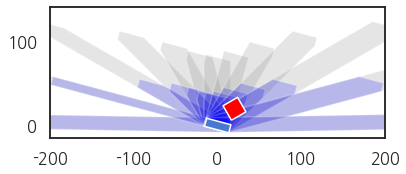

In [14]:
fig, ax = plt.subplots()
shadows_2.plot(ax=ax, facecolor="gray", alpha=0.2)
shadows_3.plot(ax=ax, facecolor="blue", alpha=0.2)
rec.plot(ax=ax)
tgt_rec.plot(ax=ax, facecolor="red")
ax.set_xlim(-200, 200)

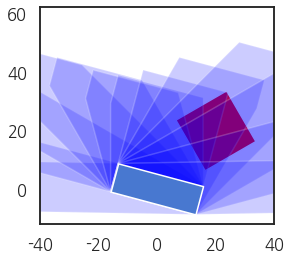

In [15]:
fig, ax = plt.subplots()
shadows_3.plot(ax=ax, facecolor="blue", alpha=0.2, zorder=2)
rec.plot(ax=ax, zorder=3)
tgt_rec.plot(ax=ax, facecolor="red", zorder=1)
ax.set_xlim(-40, 40)
ax.set_aspect("equal")

In [28]:
from copy import deepcopy
shadows_tmp = deepcopy(shadows_3)

intersections = []
for i in range(shadows_tmp.shape[0]):
    intersection = shadows_tmp.loc[i, "geometry"].intersection(tgt_rec.loc[0, "geometry"])
    intersections.append(intersection)

<AxesSubplot:>

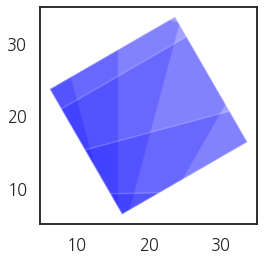

In [29]:
shadows_on_target = gpd.GeoDataFrame({"geometry":intersections})
shadows_on_target["area"] = shadows_on_target["geometry"].area
shadows_on_target.query("area > 0").plot(facecolor="b", alpha=0.2)

In [30]:
tgt_area = tgt_rec["geometry"].area.values[0]

shadows_on_target["loss_ratio"] = shadows_on_target["area"]/tgt_area
display(shadows_on_target)

loss_ratio = shadows_on_target["loss_ratio"].mean()*100
print(f"irradion loss ratio = {loss_ratio:.1f} %")

,geometry,area,loss_ratio
0,POLYGON EMPTY,0.000000,0.000000
1,POLYGON EMPTY,0.000000,0.000000
2,POLYGON EMPTY,0.000000,0.000000
3,POLYGON EMPTY,0.000000,0.000000
4,POLYGON EMPTY,0.000000,0.000000
5,"POLYGON ((9.24728 25.33892, 12.60461 12.80919,...",21.033220,0.052583
6,"POLYGON ((15.78298 29.11231, 15.78298 7.30409,...",102.970096,0.257425
7,"POLYGON ((22.87366 33.20611, 24.11439 32.87366...",223.115652,0.557789
8,"POLYGON ((30.65931 21.53753, 24.65744 11.14197...",368.803558,0.922009
9,"POLYGON ((16.33975 6.33975, 6.33975 23.66025, ...",400.000000,1.000000


irradion loss ratio = 31.0 %


In [19]:
def create_shadow_4(lat, 
                   src_x, src_y, src_width, src_height, src_tall, src_angle,
                   tgt_x, tgt_y, tgt_width, tgt_height, tgt_tall, tgt_angle,
                   on, intersection=True, sun_resolution=13):
    sign = np.sign(lat)
    if sign >= 0:
        Hs = np.linspace(90, 270, sun_resolution)
    else:
        Hs = np.linspace(270, 450, sun_resolution)
    Hs[0] += 1
    Hs[-1] -= 1
    As = sign * np.rad2deg(np.arcsin(np.cos(np.deg2rad(lat))*np.cos(np.pi - np.deg2rad(Hs))))
    
    # target building
    tgt_rec = create_rec(20, 20, 20, 20, 60)
    tgt_area = tgt_rec["geometry"].area.values[0]
    
    # relative height 
    rel_tall = src_tall - tgt_tall
    if rel_tall < 0:
        rel_tall = 0
        
    if on == "ground":
        tall = src_tall
    else: # if on == "target"
        tall = rel_tall
    
    def get_shadows(tall, As, Hs, on):
        assert on in ["ground", "target"]
        
        # shadow length
        ls = tall/np.tan(np.deg2rad(As))
        
        # shadow points
        s_points = []
        rec = create_rec(src_x, src_y, src_width, src_height, src_angle)
        points = rec.loc[0, "points"]
        
        for px, py in points:
            sx = px-ls*np.sin(np.deg2rad(Hs))
            sy = py-ls*np.cos(np.deg2rad(Hs))
            s_points.append(list(zip(sx, sy)))

        shadows_list = []
        for i in range(len(Hs)):
            mpoints_i = MultiPoint(points + np.array(s_points)[:,i].tolist())
            shadows_list.append(mpoints_i.convex_hull)
            
        shadows = gpd.GeoDataFrame({"geometry":shadows_list})

        return shadows
    
    if on == "ground":
        shadows = get_shadows(src_tall, As, Hs, on)
        return shadows, np.nan
    
    else:
        shadows = get_shadows(rel_tall, As, Hs, on)        
        
        # shadow on target building
        if intersection:
            intersections = []
            for i in range(shadows.shape[0]):
                intersection = shadows.loc[i, "geometry"].intersection(tgt_rec.loc[0, "geometry"])
                intersections.append(intersection)
                
            shadows_on_target = gpd.GeoDataFrame({"geometry":intersections})
            shadows_on_target["area"] = shadows_on_target["geometry"].area
            shadows_on_target["loss_ratio"] = shadows_on_target["area"]/tgt_area
            loss_ratio = shadows_on_target["loss_ratio"].mean()*100
            
            return shadows_on_target, loss_ratio
    
        else:
            return shadows, np.nan
    
    
shadows_4, loss_ratio = create_shadow_4(37, 0, 0, 30, 10, 100, 15,
                                        20, 20, 20, 20, 60, 60,
                                        "target", sun_resolution=101
                                        )    
display(shadows_4)
print(f"irradion loss ratio = {loss_ratio:.1f} %")

,geometry,area,loss_ratio
0,POLYGON EMPTY,0.000000,0.000000
1,POLYGON EMPTY,0.000000,0.000000
2,POLYGON EMPTY,0.000000,0.000000
3,POLYGON EMPTY,0.000000,0.000000
4,POLYGON EMPTY,0.000000,0.000000
...,...,...,...
96,"POLYGON ((13.05557 12.02811, 29.87182 14.15249...",51.316884,0.128292
97,"POLYGON ((13.51260 11.23651, 27.03520 12.51477...",34.915382,0.087288
98,"POLYGON ((13.98297 10.42179, 24.56298 11.08743...",22.378430,0.055946
99,"POLYGON ((14.46826 9.58126, 22.38515 9.83006, ...",13.064171,0.032660


irradion loss ratio = 33.4 %


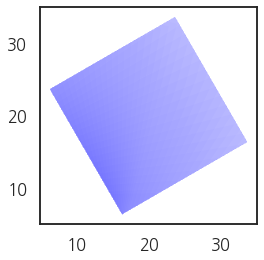

In [20]:
fig, ax = plt.subplots()
shadows_4.query("area > 0").plot(ax=ax, facecolor="blue", alpha=0.01, zorder=2)
ax.set_aspect("equal")

### Comparison with Paper

In [21]:
# source building

src_width = 6
src_height = 4
src_tall = 8
src_angle = -45

In [22]:
# latitudes
cities = ["Philadelphia", "Adderly", "Agua Blanca", "Antofagasta", "Los Lagos"]
lats = [39+57/60, 23+36/60, -2/60, -(23+39/60), -(39+51/60)]

In [23]:
shadows_p = {}

rec_p = create_rec(0, 0, src_width, src_height, src_angle)

for city, lat in zip(cities, lats):
    shadows_ = create_shadow_2(lat, 0, 0, src_width, src_height, src_tall, src_angle)    
    shadows_p[city] = shadows_
    

<AxesSubplot:>

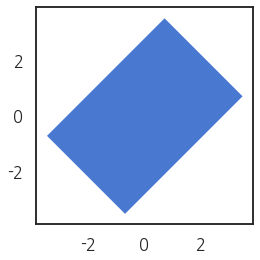

In [32]:
rec_p.plot()

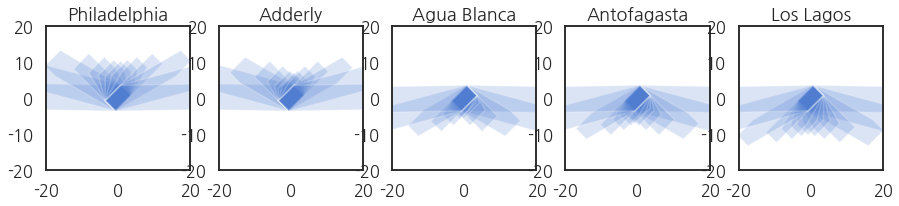

In [33]:
fig, axs = plt.subplots(ncols=5, figsize=(15, 3))

rec_p.plot(ax=ax)

for city, ax in zip(cities, axs):    
    shadows_p[city].plot(ax=ax, alpha=0.2)
    ax.set_xlim(-20, 20)
    ax.set_ylim(-20, 20)
    ax.set_title(f"{city}")

In [ ]:
lats[2]

In [50]:
from pysolar.solar import get_altitude, get_azimuth
import datetime

In [140]:
alts = []
azis = []
KST = datetime.timezone(datetime.timedelta(hours=9))
# lat, lon = 37.5665, 126.9780 # seoul
# lat, lon = 35.6762, 139.6503 # tokyo
lat, lon = 36.3504, 127.3845 # daejeon
# lat, lon = 63.63504, 127.3845

for hr in range(24):
    date = datetime.datetime(2017, 3, 21, hr, 0, 0, tzinfo=KST)
    alts.append(get_altitude(lat, lon, date))
    azis.append(get_azimuth(lat, lon, date))
    
print(list(zip(alts, azis)))

[(-52.535823996686474, 344.34935602966243), (-53.19642075873801, 9.304032575800505), (-48.85146469592061, 32.25747067832452), (-40.83703140851981, 50.24003278189258), (-30.67366620572828, 63.89588529480109), (-19.360347446382853, 74.80193098643757), (-7.478706989943731, 84.23991318522698), (4.768426971354727, 93.15925050371266), (16.625603732296074, 102.37771797044769), (28.124858439997052, 112.79376124592058), (38.67966646522917, 125.60042677857274), (47.40918973447565, 142.37383302162425), (52.89168933097318, 164.28463877268788), (53.57702210048166, 189.44917229657798), (49.21847773664766, 212.58003727778618), (41.17828191869954, 230.6448945114572), (30.999680704935944, 244.32911708209883), (19.69374451306373, 255.2485118313062), (7.880415586921501, 264.70227999884), (-4.29113391589842, 273.64661279664324), (-16.22779360365877, 282.9012247654504), (-27.69413743353051, 293.36082478092845), (-38.174967247099694, 306.19896701128), (-46.797194661315245, 322.93002154549225)]


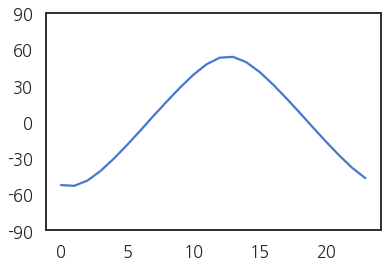

In [141]:
fig, ax = plt.subplots()
ax.plot(list(range(24)), alts)
ax.set_ylim(-90, 90)
ax.set_yticks(np.linspace(-90, 90, 7))
plt.show()

In [122]:
if lat >= 0:
    Hs = np.linspace(90, 270, 25)
    sign = 1
else:
    Hs = np.linspace(270, 450, 25)
    sign = -1
Hs[0] += 1
Hs[-1] -= 1
As = sign * np.rad2deg(np.arcsin(np.cos(np.deg2rad(lat))*np.cos(np.pi - np.deg2rad(Hs))))
print(lat, As)

36.3504 [ 0.80539284  6.03446842 12.03181052 17.95175091 23.747303   29.36035704
 34.71598687 39.71524395 44.2270193  48.0817883  51.07450297 52.98870333
 53.6496     52.98870333 51.07450297 48.0817883  44.2270193  39.71524395
 34.71598687 29.36035704 23.747303   17.95175091 12.03181052  6.03446842
  0.80539284]


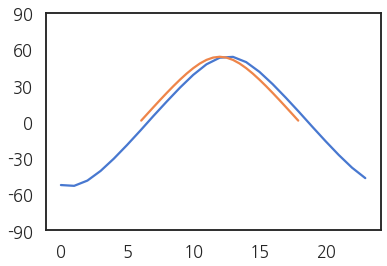

In [123]:
fig, ax = plt.subplots()
ax.plot(list(range(24)), alts)
ax.plot(Hs/360*24, As)
ax.set_ylim(-90, 90)
ax.set_yticks(np.linspace(-90, 90, 7))
plt.show()

In [126]:
ls = 1/np.tan(np.deg2rad(As))

px = -ls * np.sin(np.deg2rad(Hs))
py = -ls * np.cos(np.deg2rad(Hs))

(0.0, 1.2667631489230273)

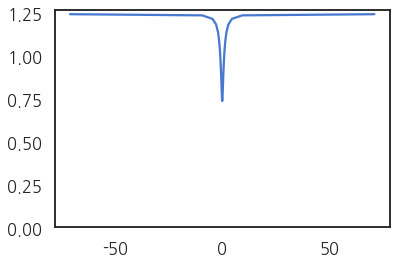

In [136]:
fig, ax = plt.subplots()
ax.plot(px, py)
ax.set_ylim(0,)
# ax.set_xlim(-20, 20)

(-20.0, 20.0)

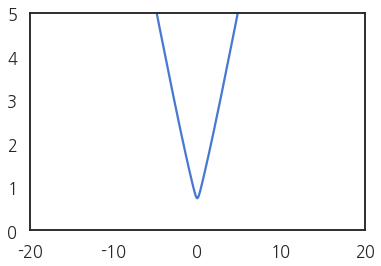

In [135]:
fig, ax = plt.subplots()
ax.plot(px, ls)
ax.set_ylim(0,5)
ax.set_xlim(-20, 20)

(-20.0, 20.0)

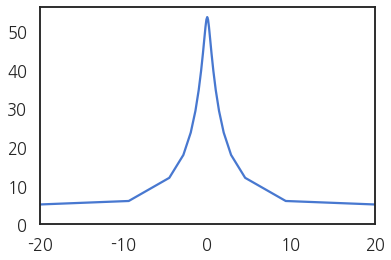

In [134]:
fig, ax = plt.subplots()
ax.plot(px, As)
ax.set_ylim(0,)
ax.set_xlim(-20, 20)

In [137]:
py

array([1.24148529, 1.234728  , 1.21433234, 1.18116202, 1.13648155,
       1.08212746, 1.02058332, 0.95508157, 0.88971362, 0.82947992,
       0.78011385, 0.74741381, 0.7359282 , 0.74741381, 0.78011385,
       0.82947992, 0.88971362, 0.95508157, 1.02058332, 1.08212746,
       1.13648155, 1.18116202, 1.21433234, 1.234728  , 1.24148529])